In [1]:
import pandas as pd
import numpy as np
import statistics
import math
import yfinance as yf
import matplotlib.pyplot as plt
import arch
import scipy.stats as stats
import statistics
import time
from scipy.stats import norm
from scipy.special import comb
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.linalg import toeplitz, lu, solve_triangular
from IPython.display import Markdown as md


/Users/sunyutong/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Modeling volatility

Find data for historical prices for any publicly traded equity. To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness.



In [57]:
# META data
ticker = 'META'
all_info = yf.Ticker(ticker)
close = all_info.history(period='5y')['Close']
close.head()

Date
2018-10-29 00:00:00-04:00    142.089996
2018-10-30 00:00:00-04:00    146.220001
2018-10-31 00:00:00-04:00    151.789993
2018-11-01 00:00:00-04:00    151.750000
2018-11-02 00:00:00-04:00    150.350006
Name: Close, dtype: float64

In [58]:
# variables
dt = 1
timestamp = close.index
log_S = np.log(close)
diff_log_S = np.diff(log_S)
S = close[-1]  # today's price
date = all_info.options[-1]
max_iter = 10000
N = len(diff_log_S) # data length
geo_brownian_rate = 0
geo_brownian_volatility = 0
GARCH_rate = 0
GARCH_para = dict()
risk_free_rate = (1+4.25/100)**(1/252)-1
recent_volatility = 0
mean_vol = 0
epsilon = 0
l = 0.1
mc_trial = 10000
discretize_step = 100

In [59]:
# Geometric Brownian motion
def fit_geo_brownian(diff_log_S): 
    sigma = math.sqrt(statistics.variance(diff_log_S))  # per day
    rate = statistics.mean(diff_log_S)+.5*sigma**2  # per day
    mean = statistics.mean(diff_log_S) # per day
    print("sigma per unit time is " + str(sigma))
    print("growth per unit time is " + str(rate))
    print("mean return is " + str(mean))
    return rate, sigma

In [60]:
gbm_rate, gbm_sigma = fit_geo_brownian(diff_log_S)
mean_vol = gbm_sigma
geo_brownian_volatility = gbm_sigma
geo_brownian_rate = gbm_rate

sigma per unit time is 0.02822560091315696
growth per unit time is 0.000961809158288515
mean return is 0.0005634668848341116


simulate the stock price using Geometic Brown Motion.
$$
S_t = S_{t-1}e^{(\mu-\frac{\sigma^2}{2})dt+\sigma z \sqrt{dt}}
$$

In [72]:
def simulate_geo_brownian(close, rate, sigma, dt):
    z = np.random.normal(0, 1, size = len(close) - 1)
    r_t = (rate - .5 * sigma ** 2) * dt + z * sigma * np.sqrt(dt)
    cum_r_t = np.cumsum(r_t)
    simu_close = pd.Series(index = close.index, dtype='float64')
    simu_close[0] = close[0]
    simu_close[1:] = close[0] * np.exp(cum_r_t)
    return simu_close

In [73]:
np.random.seed(36)
simu_close = simulate_geo_brownian(close, gbm_rate, gbm_sigma, dt)
print(simu_close.std())
print(close.std())


41.69781343137273
69.03270716061981


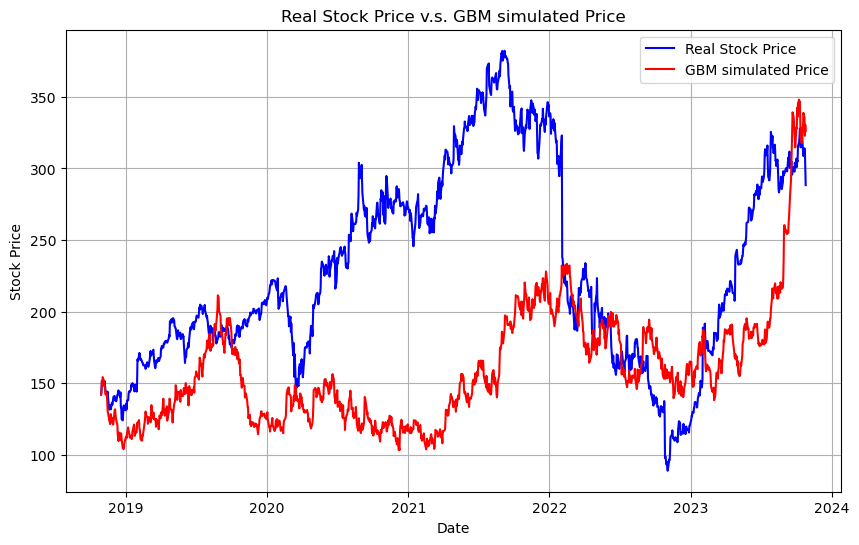

In [74]:
plt.figure(figsize=(10, 6))

plt.plot(close.index, close.values, label='Real Stock Price', color='blue')
plt.plot(simu_close.index, simu_close.values, label='GBM simulated Price', color='red')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Real Stock Price v.s. GBM simulated Price')
plt.legend()
plt.grid(True)
plt.show()

Use Garch to model volatility

GARCH(1,1) model:
$$
\begin{aligned}
a_t &= \sigma_t \varepsilon_t \\
\sigma_t^2 & = \alpha_0 + \alpha_1 a_{t-1}^2+\beta_1 \sigma_{t-1}^2
\end{aligned}
$$

In [2]:
#GARCH(1,1) model
def fit_GARCH_arch(diff_log_S, timestamp):  
    scale = 100
    model = arch.arch_model(scale * diff_log_S, vol='Garch', p=1, o=0, q=1, dist='Normal')
    results = model.fit()
    print(results.summary())
    print(results.loglikelihood)
    fitted_volatility = results.conditional_volatility / scale
    GARCH_rate = results.optimization_result['x'][0] / scale
    GARCH_para['a'] = results.optimization_result['x'][1] / (scale**2)
    GARCH_para['b'] = results.optimization_result['x'][2]
    GARCH_para['c'] = results.optimization_result['x'][3]
    recent_volatility = fitted_volatility[-1]
    print(timestamp)
    plt.plot(timestamp,fitted_volatility)
    plt.title('Fitted Conditional Volatility')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7505.002956699145
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3793.1766485672124
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3434.9270227693014
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3003.053580280952
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3128.904846627939
Iteration:      6,   Func. Count:     40,   Neg. LLF: 3014.8627818376253
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3002.1967711367624
Iteration:      8,   Func. Count:     51,   Neg. LLF: 3002.19575602181
Iteration:      9,   Func. Count:     56,   Neg. LLF: 3002.19572184542
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3002.1957139199476
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3002.19571391952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3002.1957139199476
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations:

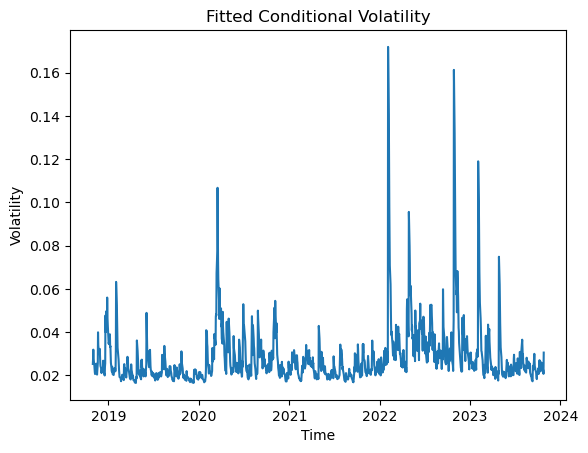

In [65]:
fit_GARCH_arch(diff_log_S, timestamp[1:])

The conditional volatility generated by GARCH(1,1) model are plotted as above. 

The GARCH model is:
$$
\begin{aligned}
a_t &= \sigma_t \varepsilon_t \\
\sigma_t^2 & = 0.8537\times10^{-4} + 0.3087 a_{t-1}^2+0.6645 \sigma_{t-1}^2
\end{aligned}
$$

plot volatility smile

In [3]:
def call_price_and_vega(para):
    S = para['S']
    delta_T = para['delta_T']
    r = para['r']
    sigma = para['sigma']
    K = para['K']
    d1 = 1/ (sigma*math.sqrt(delta_T))*(math.log(S/K)+(r+(sigma**2)/2)*delta_T)
    d2 = 1/ (sigma*math.sqrt(delta_T))*(math.log(S/K)+(r-(sigma**2)/2)*delta_T)
    vega = S*stats.norm.pdf(d1)*delta_T
    price = stats.norm.cdf(d1)*S - stats.norm.cdf(d2)*K*math.exp(-r*delta_T)
    return price, vega

def put_price_and_vega(para):
    S = para['S']
    delta_T = para['delta_T']
    r = para['r']
    sigma = para['sigma']
    K = para['K']
    d1 = 1/ (sigma*math.sqrt(delta_T))*(math.log(S/K)+(r+(sigma**2)/2)*delta_T)
    d2 = 1/ (sigma*math.sqrt(delta_T))*(math.log(S/K)+(r-(sigma**2)/2)*delta_T)
    vega = S*stats.norm.pdf(d1)*delta_T
    price = stats.norm.cdf(-d2)*K*math.exp(-r*delta_T) - stats.norm.cdf(-d1)*S
    return price, vega

def bisec_call_implied_vol(para, call_price):
    min_vol = 0
    max_vol = 10
    for _ in range(200):
        para['sigma'] = (max_vol + min_vol) / 2
        BS_price, _ = call_price_and_vega(para)
        if BS_price > call_price:
            max_vol = (max_vol + min_vol) / 2
        else:
            min_vol = (max_vol + min_vol) / 2
    return (max_vol + min_vol) / 2

def bisec_put_implied_vol(para, put_price):
    min_vol = 0
    max_vol = 10
    for _ in range(200):
        para['sigma'] = (max_vol + min_vol) / 2
        BS_price, _ = put_price_and_vega(para)
        if BS_price > put_price:
            max_vol = (max_vol + min_vol) / 2
        else:
            min_vol = (max_vol + min_vol) / 2
    return (max_vol + min_vol) / 2

def volatility_smile(option_info, date, S, risk_free_rate, mean_vol):
    OTM_call_info = option_info.calls[(option_info.calls['inTheMoney'] == False) & (option_info.calls['strike'] >= 10)]
    OTM_put_info = option_info.puts[(option_info.puts['inTheMoney'] == False) & (option_info.puts['strike'] >= 10)] 
    today = datetime.now()
    expire_date = pd.to_datetime(date)
    delta_T = int(((expire_date - today).total_seconds()) / (24*3600)) + 1
    para = dict()
    para['S'] = S
    para['delta_T'] = delta_T
    para['r'] = risk_free_rate
    K_list = list()
    implied_vol_list = list()
    for i in list(OTM_put_info.index):
        K = OTM_put_info.loc[i, 'strike']
        K_list.append(K)
        put_price = option_info.puts.loc[i, 'lastPrice']
        para['K'] = K
        para['sigma'] = mean_vol
        implied_vol_list.append(bisec_put_implied_vol(para, put_price))
    for i in list(OTM_call_info.index):
        K = OTM_call_info.loc[i, 'strike']
        K_list.append(K)
        call_price = option_info.calls.loc[i, 'lastPrice']
        para['K'] = K
        para['sigma'] = mean_vol
        implied_vol_list.append(bisec_call_implied_vol(para, call_price))
    return K_list, implied_vol_list

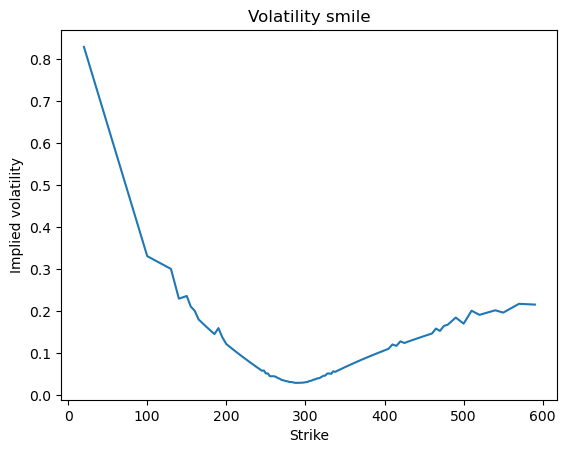

In [77]:
date = all_info.options[0]
option_info = all_info.option_chain(date=date)
K_list, implied_vol_list = volatility_smile(option_info, date, S, risk_free_rate, gbm_sigma)

plt.plot(K_list, implied_vol_list)
plt.title('Volatility smile')
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.show()

term structure of volatility


In [85]:
def volatility_term_structure(close, risk_free_rate, mean_vol, K):
    # option_info = all_info.option_chain()
    S = close[-1]
    today = datetime.now().date()
    today = datetime(today.year, today.month, today.day, 0, 0, 0)
    expire_dates = all_info.options
    if datetime.strptime(expire_dates[0], '%Y-%m-%d') <= today:
        expire_dates = expire_dates[1:]
        
    t_list = list()
    implied_vol_list = list()
    
    for expire_date in expire_dates:
        delta_T = (datetime.strptime(expire_date, '%Y-%m-%d') - today).days
        t_list.append(delta_T)
        opt = all_info.option_chain(expire_date)
        call_info = opt.calls
        call_info = call_info[call_info['strike'] == K]
        call_price = call_info.iloc[0, 3]
        para = dict()
        para['S'] = S
        para['delta_T'] = delta_T
        para['r'] = risk_free_rate
        para['sigma'] = mean_vol
        para['K'] = K
        implied_vol_list.append(bisec_call_implied_vol(para, call_price))
    return t_list, implied_vol_list

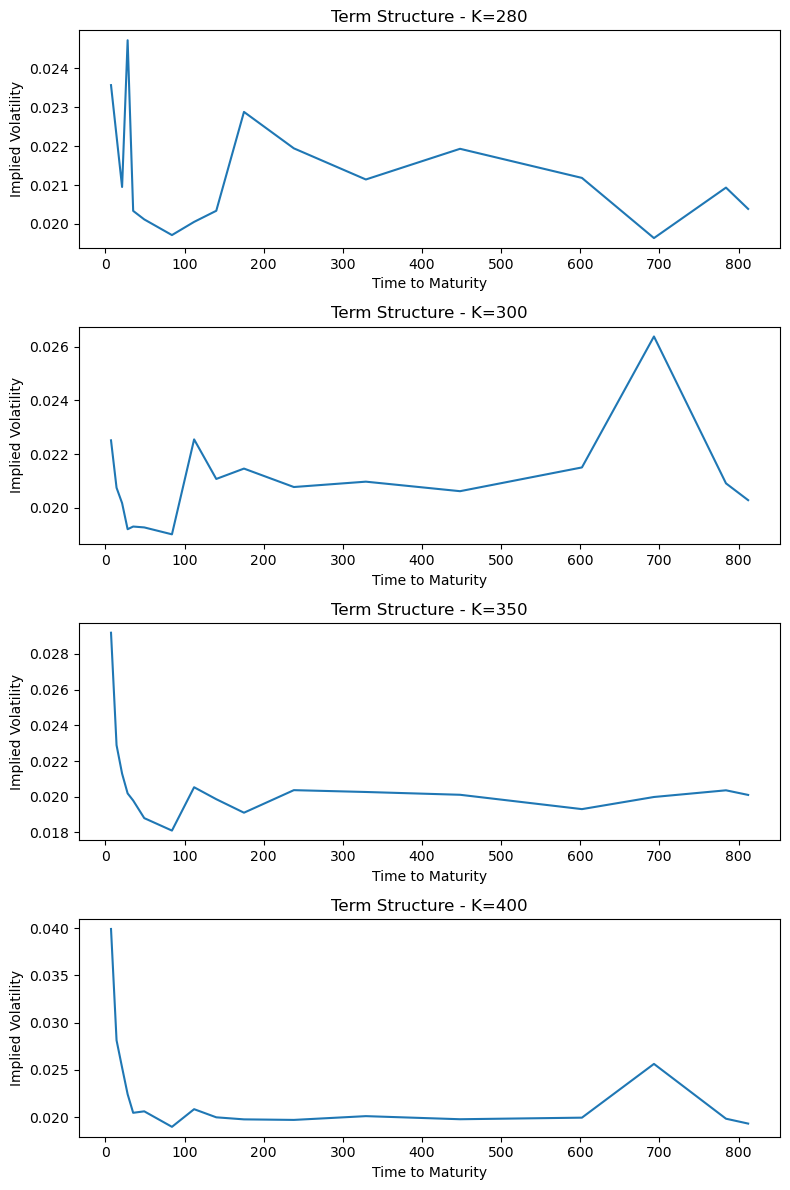

In [87]:
K_list_ = [280, 300, 350, 400]

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

for i, K_value in enumerate(K_list_):
    t_list, implied_vol_list = volatility_term_structure(close, risk_free_rate, mean_vol, K_value)
    axs[i].plot(t_list, implied_vol_list)
    axs[i].set_title(f'Term Structure - K={K_value}')
    axs[i].set_xlabel('Time to Maturity')
    axs[i].set_ylabel('Implied Volatility')

plt.tight_layout()
plt.show()

In [26]:
def volatility_surface(all_info, S, risk_free_rate, mean_vol): 
    dates = all_info.options
    today = datetime.now()
    K_dict = dict()
    t_list = list()
    implied_vol_dict = dict()
    for date in dates:
        expire_date = pd.to_datetime(date)
        delta_T = int(((expire_date - today).total_seconds()) / (24*3600)) + 1
        t_list.append(delta_T)
        option_info = all_info.option_chain(date=date)
        K_list, implied_vol_list = volatility_smile(option_info, date, S, risk_free_rate, mean_vol)
        K_dict[delta_T] = K_list
        implied_vol_dict[delta_T] = implied_vol_list
    K_set = set()
    for key in K_dict.keys():
        K_set = K_set.union(set(K_dict[key]))
    K_list = sorted(list(K_set))
    for key in implied_vol_dict.keys():
        fx = interp1d(K_dict[key], implied_vol_dict[key], 'linear', fill_value='extrapolate')
        K_dict[key] = K_list
        implied_vol_dict[key] = fx(K_list)
    implied_vol_dict_mesh = np.array([implied_vol_dict[key] for key in implied_vol_dict.keys()])
    x = np.array(t_list)
    y = np.array(K_list/S)
    X, Y = np.meshgrid(x, y)
    z = np.squeeze(implied_vol_dict_mesh).T
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, z, cmap='viridis')

    ax.set_xlabel('time to mature')
    ax.set_ylabel('moneyness')
    ax.set_zlabel('implied_vol_dict_mesh')
    ax.set_title('Surface Plot')

    # Add a color bar
    fig.colorbar(surface, shrink=0.5, aspect=10)

    # Show the plot
    plt.show()


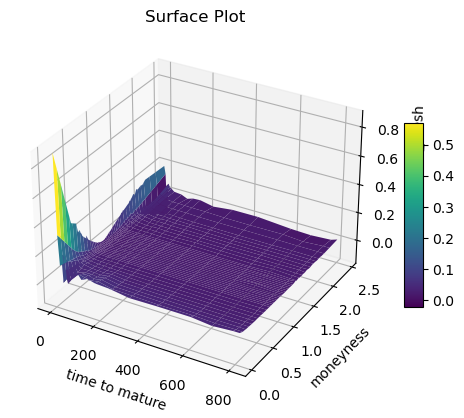

In [27]:
volatility_surface(all_info, S, risk_free_rate, mean_vol)

vanilla option pricing


In [69]:
# DataFrame where results will be saved
Prices_results = pd.DataFrame()
K = [260, 265, 270, 275, 280, 285, 290]
Prices_results.index = K
Prices_results['Real_Prices'] = [41.54, 36.95, 31.85, 29.26, 26.20, 22, 19.17]

Set maturity equals to 1 day, strike prices equal to 260, 265, 270, 275, 280, 285,and 290, respectively.

### Monte Carlo

In [29]:
def Monte_Carlo(strike, delta_T = 1):
    price_list = list()
    current_price = S
    for _ in range(mc_trial):
        sigma = recent_volatility / math.sqrt(discretize_step)
        y = (diff_log_S[-1] / discretize_step - (risk_free_rate / discretize_step - .5*(sigma**2)))
        sum_diff_log_S = 0
        for _ in range(delta_T * discretize_step):
            sigma = math.sqrt(GARCH_para['a'] / discretize_step + GARCH_para['b']*(y**2) + GARCH_para['c']*(sigma**2))
            diff_log_S_1 = (risk_free_rate / discretize_step - .5*(sigma**2)) + sigma*np.random.normal(0, 1, 1)
            y = (diff_log_S_1 - (risk_free_rate / discretize_step - .5*(sigma**2)))
            sum_diff_log_S += diff_log_S_1
        price_list.append(math.exp(sum_diff_log_S + math.log(current_price)))
    return_list = [x-strike if x-strike>=0 else 0 for x in price_list]
    euro_call_price = exp(-risk_free_rate*delta_T)*statistics.mean(return_list)
    return euro_call_price

MC = []
for i in K:
    MC.append(Monte_Carlo(i))

# Predicted Prices using Monte Carlo Method
MC

[28.676574185792056,
 24.15943485711745,
 19.07018944689086,
 14.334638704478987,
 10.378034850538773,
 7.08757150156643,
 4.397925352510872]

### Numerical PDE

computation time :13.464383125305176 seconds


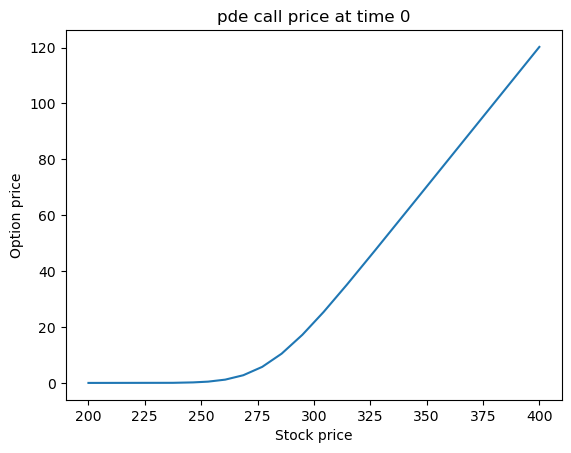

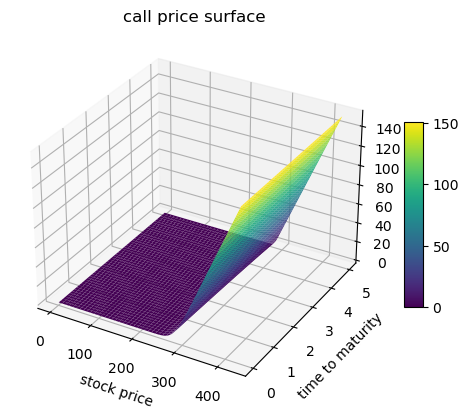

stock price is: 288.3500061035156
time to maturity is: 5
strike price is: 280
European call option price is: 12.40775685216439
computation time :13.549175024032593 seconds
computation time :13.733605146408081 seconds
computation time :13.529691219329834 seconds
computation time :13.588354110717773 seconds
computation time :13.7326819896698 seconds
computation time :13.892704010009766 seconds
computation time :13.838582992553711 seconds


In [82]:
def pde_european_call(para, plot_flag=False):
    delta_T = para["delta_T"]
    N_t = para["N_t"]
    N_x = para["N_x"]
    K = para["strike"]
    S = para["price"]
    S_max = para["S_max"]
    x_max = np.log(S_max/K)
    x_min = -10
    sigma = para["geo_brownian_volatility"]
    r = para["risk_free_rate"]
    k = 2*r / (sigma**2)
    alpha = -0.5 * (k-1)
    beta = -0.25*((k+1)**2)
    tau_max = delta_T*0.5*(sigma**2)
    tau_grid = np.atleast_2d(np.linspace(0, tau_max, N_t+1))
    x_grid = np.atleast_2d(np.linspace(x_min, x_max, N_x+1))
    dx = (x_max - x_min) / N_x
    dtau = delta_T*0.5*(sigma**2) / N_t
    dim_ratio = dtau / (dx**2)
    u_table = np.empty((N_x+1, N_t+1))
    # determin boundary condition
    v_low_boundary = np.zeros((1, len(tau_grid)))
    v_up_boundary = (S_max/K)*np.ones((1, len(tau_grid))) - np.atleast_2d(np.exp(-2*r*tau_grid/(sigma**2)))
    u_low_boundary = np.exp(-alpha*(-5)-beta*tau_grid)*v_low_boundary
    u_up_boundary = np.exp(-alpha*x_max-beta*tau_grid)*v_up_boundary
    u_ini = np.atleast_2d(np.exp(0.5*(1+k)*x_grid)-np.exp(0.5*(k-1)*x_grid))
    u_ini[u_ini<0] = 0
    u_ini = u_ini.T
    u_table[:, 0] = u_ini[:, 0]
    u_table[0, :] = u_low_boundary[0, :]
    u_table[-1, :] = u_up_boundary[0, :]
    # determine system matrices for Crank-Nicolson method
    row_vector = np.array([[0.5*dim_ratio, 1-dim_ratio, 0.5*dim_ratio] + [0] * (N_x - 2)])
    col_vector = (np.array([[0.5*dim_ratio] + [0] * (N_x - 2)])).T
    Z_matrix = toeplitz(col_vector, row_vector)
    row_vector = np.array([[-0.5*dim_ratio, 1+dim_ratio, -0.5*dim_ratio] + [0] * (N_x - 2)])
    row_vector = np.array([1+dim_ratio, -0.5*dim_ratio] + [0] * (N_x - 3))
    col_vector = row_vector.T
    C = toeplitz(col_vector, row_vector)
    P, L, U = lu(C)
    # solve pde
    T1 = time.time()
    for i in range(1,N_t+1):
        b = np.atleast_2d(np.matmul(Z_matrix, u_table[:, i-1])) + 0.5*dim_ratio*np.atleast_2d(np.array([u_table[0, i]] + [0]*(N_x-3) +[u_table[-1, i]]))
        # u_table[1:-1, i] = np.squeeze(np.linalg.solve(C, b.T)) ~96 senconds
        u_table[1:-1, i] = np.squeeze(solve_triangular(U, solve_triangular(L, b.T, lower=True)))  # much faster ~12 seconds
    T2 = time.time()
    print('computation time :%s seconds' % ((T2 - T1)))
    # recover price
    v_T = np.exp(alpha*x_grid+beta*tau_max)*u_table[:,-1]
    C_0 = K*v_T
    S_grid = K*np.exp(x_grid)
    fx = interp1d(S_grid[0,:], C_0[0,:], 'linear', fill_value='extrapolate')
    stock_price_range = np.linspace(200, 400, 1000)
    option_price = fx(stock_price_range)
    if (plot_flag):
        plt.plot(stock_price_range, option_price)
        plt.title('pde call price at time 0')
        plt.xlabel('Stock price')
        plt.ylabel('Option price')
        plt.show()
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        t_grid = delta_T - 2*tau_grid / (sigma**2)
        S_space = np.linspace(1, 1.5*S, 100)
        c = K*np.exp(beta*tau_grid + alpha*(x_grid).T) * u_table
        c_interp = RegularGridInterpolator((np.squeeze(S_grid), np.squeeze(t_grid)), c)
        X, Y = np.meshgrid(S_space, t_grid)
        surface = ax.plot_surface(X, Y, c_interp((X, Y)), cmap='viridis')

        ax.set_xlabel('stock price')
        ax.set_ylabel('time to maturity')
        ax.set_zlabel('call price')
        ax.set_title('call price surface')

        # Add a color bar
        fig.colorbar(surface, shrink=0.5, aspect=10)

        # Show the plot
        plt.show()
        print("stock price is: " + str(S))
        print("time to maturity is: " + str(delta_T))
        print("strike price is: " + str(K))
        print("European call option price is: " + str(fx(S)))
        return 0
    else:
        return fx(para["price"])

def numerical_PDE(strike, delta_T = 1):

    para = dict()
    para["strike"] = strike
    para["delta_T"] = delta_T
    para["price"] = S
    para["risk_free_rate"] = risk_free_rate
    para["discretize_step"] = discretize_step
    para["geo_brownian_volatility"] = geo_brownian_volatility
    para["mc_trial"] = mc_trial
    para["N_t"] = 40000 # grid number of t
    para["N_x"] = 400  # grid number of x
    para["S_max"] = 10*S # consider as infty

    return pde_european_call(para)
# plot option price surface

para = dict()
para["strike"] = strike
para["delta_T"] = delta_T
para["price"] = S
para["risk_free_rate"] = risk_free_rate
para["discretize_step"] = discretize_step
para["geo_brownian_volatility"] = geo_brownian_volatility
para["mc_trial"] = mc_trial
para["N_t"] = 40000 # grid number of t
para["N_x"] = 400  # grid number of x
para["S_max"] = 10*S # consider as infty

pde_european_call(para, True)

nPDE=[]
for i in K:
    nPDE.append(numerical_PDE(i))

In [83]:
n = [float(nPDE[i]) for i in range(len(nPDE))]
n

[28.40125601498255,
 23.415540320874022,
 18.509756421294952,
 13.653994037072366,
 9.300344138304814,
 5.252405880029008,
 2.595454263269179]

### Binomial tree for European call pricing

In [39]:
def Binomial_tree(strike, delta_T = 1):
    n = discretize_step
    u = exp(geo_brownian_volatility/sqrt(n))
    d = 1 / u
    r = (1 + risk_free_rate)**(1/n)-1
    p_u = (exp(r) - d) / (u - d)
    success_array = np.array(range(delta_T*n+1))
    comb_array = comb(delta_T*n, success_array)
    prob_array = comb_array * (p_u**(success_array)*(1-p_u)**(delta_T*n-success_array))
    price_array = S*u**(success_array)*d**(delta_T*n-success_array)-strike
    price_array[price_array<0] = 0
    price = sum(price_array*prob_array)
    return price

BT = []
for i in K:
    BT.append(Binomial_tree(i))
    
# # Predicted Prices using Numerical PDE Method
BT

[28.397838516667257,
 23.400511064860968,
 18.423406053757134,
 13.547304916274275,
 9.009296035192294,
 5.205590769924388,
 2.5215035063595517]

### Black-Scholes formula

In [40]:
def Black_Scholes(strike, delta_T = 1):
    sigma = geo_brownian_volatility
    r = risk_free_rate
    d1 = 1/ (sigma*math.sqrt(delta_T))*(math.log(S/strike)+(r+(sigma**2)/2)*delta_T)
    d2 = 1/ (sigma*math.sqrt(delta_T))*(math.log(S/strike)+(r-(sigma**2)/2)*delta_T)
    price = stats.norm.cdf(d1)*S - stats.norm.cdf(d2)*strike*math.exp(-r*delta_T)
    return price

BS = []
for i in K:
    BS.append(Black_Scholes(i))
    
# # Predicted Prices using Numerical PDE Method
BS

[28.393173585308716,
 23.396781003212254,
 18.420579438773757,
 13.54603988969609,
 9.006736738525234,
 5.206613019441676,
 2.5173215400999993]

### Comparison

In [4]:
# Integration of results
Prices_results['Monte_Carlo'] = MC
Prices_results['numerical_PDE'] = n
Prices_results['Binomial_tree'] = BT
Prices_results['Black_Scholes'] = BS

Prices_results

NameError: name 'MC' is not defined

### Accuracy
The Numerical PDE, Binomial Tree, and Black-Scholes methods seem to be fairly consistent with each other, but they undervalue the options when compared to the real prices. Among these, Black-Scholes is slightly more accurate.
The Monte Carlo method seems to be the least accurate, showing significant discrepancies from the real prices, especially as the strike price increases.

### Efficiency

Black-Scholes is highly efficient as it provides a closed-form solution, making it computationally less demanding.
The Binomial Tree method's efficiency can vary based on the number of steps used in the tree, but it's generally more efficient than Monte Carlo and Numerical PDE methods.
Numerical PDE is computationally more demanding due to the requirement of solving differential equations on a grid. Its efficiency can be improved with a better choice of discretization scheme and grid resolution.
Monte Carlo method is often the least efficient due to its reliance on random sampling, which can require a large number of simulations to achieve an accurate estimate.

## Sources of Error
1. All these methods assume certain model dynamics which may not hold in real markets, such as constant volatility or interest rates.
2. The Binomial Tree and Numerical PDE methods involve discretization, which can introduce errors, especially with coarser grids.
3. The Monte Carlo method has inherent statistical error due to the random sampling process.

### Exploring variance reduction in Monte Carlo

use the Geometric Brownian motion obtained in (variable gbm_sigma), and the same parameters defined in the beginning of this file, to calculate the price of any path-dependent option.

In [5]:
# indicate parameters
strike = 280
delta_T = 5  # time to maturity
risk_free_rate = (1+4.25/100)**(1/252)-1
discretize_step = 100
mc_trial = 1000
gbm_rate, gbm_sigma = fit_geo_brownian(diff_log_S)

para = dict()
para["strike"] = strike
para["delta_T"] = delta_T
para["price"] = close[-1]
para["risk_free_rate"] = risk_free_rate
para["discretize_step"] = discretize_step
para["geo_brownian_volatility"] = gbm_sigma
para["mc_trial"] = mc_trial


NameError: name 'fit_geo_brownian' is not defined

###  Crude Monte Carlo
 


In [42]:
#  crude Monte Carlo for Asian call option
def brownian_motion_crude_mc_asian_call(para):
    K = para["strike"]
    delta_T = para["delta_T"]
    S = para["price"] 
    n = para["discretize_step"]
    geo_brownian_volatility = para["geo_brownian_volatility"]
    mc_trial = para["mc_trial"]
    r = para["risk_free_rate"]
    sigma = geo_brownian_volatility / math.sqrt(n)
    price_list = np.array([-K]*mc_trial)
    dt = 1 / n
    for i in range(mc_trial):
        log_price_list = [np.log(S)]
        for _ in range(delta_T*n):
            w = np.random.normal(0, 1)
            next_log_S = log_price_list[-1] + (r - 0.5*(sigma**2))*dt + sigma*w/math.sqrt(n)
            log_price_list.append(next_log_S)
        price_path = np.exp(log_price_list)
        price_list[i] += np.mean(price_path)
    price_list[price_list<0] = 0
    price = math.exp(-r*delta_T)*np.mean(price_list)
    return price

print("The price with crude monte carlo of an asian call is", brownian_motion_crude_mc_asian_call(para))



The price with crude monte carlo of an asian call is 7.944436019159496


### Monte Carlo Variance Reduction: Antithetic Aariate 
Use the Antithetic Aariate technique for variance reduction. Using the symmetric properties of normal distribution.
 

In [43]:
# Monte Carlo for Asian call option, with antithetic_variate 
def bronian_motion_crude_mc_asian_call_antithetic_variate(para): 
    K = para["strike"]
    delta_T = para["delta_T"]
    S = para["price"] 
    n = para["discretize_step"]
    geo_brownian_volatility = para["geo_brownian_volatility"]
    mc_trial = para["mc_trial"]
    r = para["risk_free_rate"]
    sigma = geo_brownian_volatility / math.sqrt(n)
    price_list = np.array([-K]*mc_trial)
    dt = 1 / n
    for i in range(int(mc_trial/2)):
        log_price_list_1 = [np.log(S)]
        log_price_list_2 = [np.log(S)]
        for _ in range(delta_T*n):
            w = np.random.normal(0, 1)
            next_log_S = log_price_list_1[-1] + (r - 0.5*(sigma**2))*dt + sigma*w/math.sqrt(n)
            log_price_list_1.append(next_log_S)
            next_log_S = log_price_list_2[-1] + (r - 0.5*(sigma**2))*dt - sigma*w/math.sqrt(n)
            log_price_list_2.append(next_log_S)
        price_path = np.exp(log_price_list_1)
        price_list[i] += np.mean(price_path)
        price_path = np.exp(log_price_list_2)
        price_list[int(mc_trial/2)+i] += np.mean(price_path)
    price_list[price_list<0] = 0
    price = math.exp(-r*delta_T)*np.mean(price_list)
    return price

print("The price with antithetic variate monte carlo of a asian call is", bronian_motion_crude_mc_asian_call_antithetic_variate(para))


The price with antithetic variate monte carlo of a asian call is 7.963420333631139


### Monte Carlo Variance Reduction: Control Variate 
use the Control Variate technique for variance reduction, with a european call option as control variate
 

In [44]:
# compute european call with bs formula
def european_call(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r - 0.5*(sigma**2)) * T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

# Monte Carlo for Asian call option, with_control_variate, using european call option
def brownian_motion_crude_mc_asian_call_control_variate(para):
    K = para["strike"]
    delta_T = para["delta_T"]
    S = para["price"]
    n = para["discretize_step"]
    geo_brownian_volatility = para["geo_brownian_volatility"]
    mc_trial = para["mc_trial"]
    r = para["risk_free_rate"]
    sigma = geo_brownian_volatility / math.sqrt(n)
    # european call
    european_option_price = european_call(S, K, delta_T, r, sigma)
    asian_payoffs = np.zeros(mc_trial)
    european_payoffs = np.zeros(mc_trial)
    dt = 1 / n
    for i in range(mc_trial):
        log_price_list = [np.log(S)]
        for _ in range(delta_T * n):
            w = np.random.normal(0, 1)
            next_log_S = log_price_list[-1] + (r - 0.5 * (sigma ** 2)) * dt + sigma * w * math.sqrt(dt)
            log_price_list.append(next_log_S)

        price_path = np.exp(log_price_list)
        asian_payoffs[i] = max(np.mean(price_path) - K, 0)  # Asian option payoff
        european_payoffs[i] = max(price_path[-1] - K, 0)

    # calculating the sample covariances and variances needed for the control variate correction
    cov_xy = np.mean((european_payoffs - european_option_price) * (asian_payoffs - np.mean(asian_payoffs)))
    var_x = np.mean((european_payoffs - european_option_price) ** 2)
    # caclculate control variate coefficient
    c = -cov_xy / var_x
    # adjust asian option price 
    price_list = asian_payoffs + c * (european_payoffs - european_option_price)
    price_list[price_list<0] = 0
    price = np.exp(-r * delta_T) * np.mean(price_list)

    return price

print("The price with control variate monte carlo of a asian call is ", brownian_motion_crude_mc_asian_call_control_variate(para))


The price with control variate monte carlo of a asian call is  8.458154623836448


By checking the results below it is clear both variance reduction works and the variance is reduced to a small proportion of original crude method stably and efficiently.

In [45]:
def asian_call_variance_comparison(para):
    trial_no = 10
    crude_mc_result = list()
    anti_mc_result = list()
    ctrl_mc_result = list()
    for _ in range(trial_no):
        crude_mc_result.append(brownian_motion_crude_mc_asian_call(para))
        anti_mc_result.append(bronian_motion_crude_mc_asian_call_antithetic_variate(para))
        ctrl_mc_result.append(brownian_motion_crude_mc_asian_call_control_variate(para))
    v1 = statistics.variance(crude_mc_result)
    v2 = statistics.variance(ctrl_mc_result)
    v3 = statistics.variance(anti_mc_result)
    print("variance of crude monte carlo is:", v1)
    print("variance of monte carlo with control_variate is:", v2)
    print("variance of monte carlo with antithetic_variate is:", v3)
    
    
    print("variance of control variate method has reduced to", round((v2/v1)*100,2), "% of variance of crude method")  

    print("variance of antithetic variate method has reduced to", round((v3/v1)*100,2), "% of variance of crude method") 
    
asian_call_variance_comparison(para)

variance of crude monte carlo is: 0.0004331616943051023
variance of monte carlo with control_variate is: 0.00016350040753716183
variance of monte carlo with antithetic_variate is: 3.221341289820571e-05
variance of control variate method has reduced to 37.75 % of variance of crude method
variance of antithetic variate method has reduced to 7.44 % of variance of crude method
